<font size="+3"><strong>Volatility Forecasting </strong></font>

Building a model to predict stock volatility.

In [59]:
# Import your libraries here
%load_ext autoreload
%autoreload 2

import os
import sqlite3
from glob import glob

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from arch import arch_model
from arch.univariate.base import ARCHModelResult
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from config import settings
from data import SQLRepository




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**1:** Creating a URL to get all the stock data.

In [60]:
# Import `AlphaVantageAPI`
from data import AlphaVantageAPI

# Create instance of `AlphaVantageAPI` class
av = AlphaVantageAPI()

print("av type:", type(av))

av type: <class 'data.AlphaVantageAPI'>


In [61]:
ticker = "TQQQ"
output_size = "full"
data_type = "json"

url = (
    "https://learn-api.wqu.edu/1/data-services/alpha-vantage/query?"
    "function=TIME_SERIES_DAILY&"
    f"symbol={ticker}&"
    f"outputsize={output_size}&"
    f"datatype={data_type}&"
    f"apikey={settings.alpha_api_key}"
)

print("url type:", type(url))


url type: <class 'str'>


**2:** Creating an HTTP request for the URL.

In [62]:
response = requests.get(url=url)

print("response type:", type(response))

response type: <class 'requests.models.Response'>


**3:** Getting status code of `response` and assign it to the variable `response_code`.

In [63]:
response_code = response.status_code

print("code type:", type(response_code))
response_code

code type: <class 'int'>


200

# Prepare Data

**4:** Creating a DataFrame.

In [64]:
response_data = response.json()

print("response_data type:", type(response_data))

response_data type: <class 'dict'>


In [65]:
# Extracting `"Time Series (Daily)"` value from `response_data`
stock_data = response_data["Time Series (Daily)"]

print("stock_data type:", type(stock_data))

# Extracting data for one of the days in `stock_data`
# stock_data.keys()
stock_data['2024-08-13']

stock_data type: <class 'dict'>


{'1. open': '61.1000',
 '2. high': '63.7100',
 '3. low': '60.9000',
 '4. close': '63.5600',
 '5. volume': '54006339'}

In [66]:
df_tqqq = pd.DataFrame.from_dict(stock_data, orient="index", dtype=float)
df_tqqq.index = pd.to_datetime(df_tqqq.index)
df_tqqq.index.name = "date"
df_tqqq.columns = [c.split(". ")[1] for c in df_tqqq.columns]
print("df_tqqq type:", type(df_tqqq))
df_tqqq.head()

df_tqqq type: <class 'pandas.core.frame.DataFrame'>


,open,high,low,close,volume
date,,,,,
2024-08-13,61.10,63.71,60.9000,63.56,54006339.0
2024-08-12,59.23,60.40,58.1146,59.25,54486320.0
2024-08-09,57.44,59.53,57.0000,58.85,62796186.0
2024-08-08,55.45,58.35,54.0100,58.06,76439627.0
2024-08-07,57.57,58.51,53.0000,53.19,91375823.0


In [67]:
#Checking for any null values and removing the null values'''
print('Null Values =',df_tqqq.isnull().values.any())
df_tqqq.head()

Null Values = False


,open,high,low,close,volume
date,,,,,
2024-08-13,61.10,63.71,60.9000,63.56,54006339.0
2024-08-12,59.23,60.40,58.1146,59.25,54486320.0
2024-08-09,57.44,59.53,57.0000,58.85,62796186.0
2024-08-08,55.45,58.35,54.0100,58.06,76439627.0
2024-08-07,57.57,58.51,53.0000,53.19,91375823.0


**5:** Adjusting the data based on historical stock splits before proceeding with further analysis.

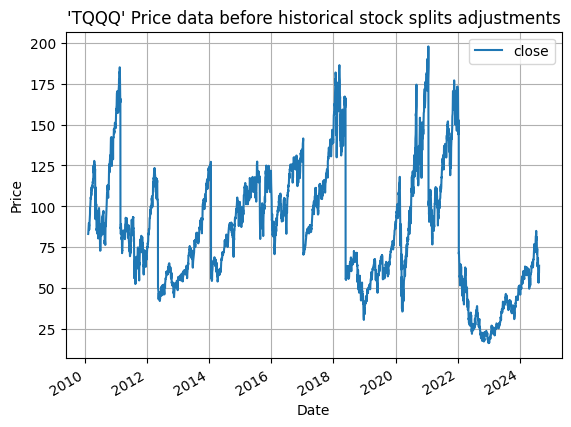

In [69]:
df_tqqq[['close']].plot(grid=True)

# Adding axis labels
plt.xlabel("Date")
plt.ylabel("Price")

# Adding title
plt.title(f"'{ticker}' Price data before historical stock splits adjustments")
plt.show();
# Adjusting the data based on historical stock splits before proceeding with further analysis.

In [93]:
# List of splits (date and ratio)
splits = [
    ('2022-01-13', 2),   # 2-for-1 split
    ('2021-01-21', 2),   # 2-for-1 split
    ('2018-05-24', 3),   # 3-for-1 split
    ('2017-01-12', 2),   # 2-for-1 split
    ('2014-01-24', 2),   # 2-for-1 split
    ('2012-05-11', 2),   # 2-for-1 split
    ('2011-02-25', 2),   # 2-for-1 split
]

# Converting dates to Timestamps
splits = [(pd.Timestamp(date), ratio) for date, ratio in splits]

# Applying adjustments for each split
for split_date, split_ratio in splits:
    df_tqqq.loc[df_tqqq.index < split_date, ['open', 'high', 'low', 'close']] /= split_ratio
    df_tqqq.loc[df_tqqq.index < split_date, 'volume'] *= split_ratio

# Verifying the adjustments
df_tqqq.head()  # Look at the data to ensure adjustments are correct

,open,high,low,close,volume
date,,,,,
2024-08-13,61.10,63.71,60.9000,63.56,54006339.0
2024-08-12,59.23,60.40,58.1146,59.25,54486320.0
2024-08-09,57.44,59.53,57.0000,58.85,62796186.0
2024-08-08,55.45,58.35,54.0100,58.06,76439627.0
2024-08-07,57.57,58.51,53.0000,53.19,91375823.0


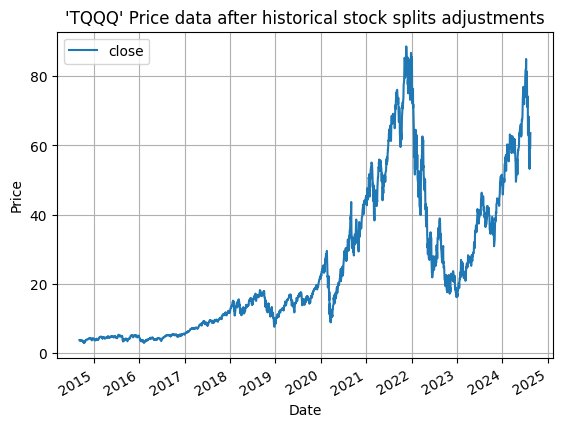

In [92]:
df_tqqq[['close']].plot(grid=True)

# Adding axis labels
plt.xlabel("Date")
plt.ylabel("Price")

# Adding title
plt.title(f"'{ticker}' Price data after historical stock splits adjustments")
plt.show();

**6:** Connecting to the database whose name is stored in the `.env` file.

In [72]:
connection = sqlite3.connect(database=settings.db_name, check_same_thread=False)
connection

**7:** Inserting data into database.

In [73]:
df_tqqq.shape

(3650, 5)

In [74]:
# Inserting data into database
repo = SQLRepository(connection=connection)
response = repo.insert_table(table_name=ticker, records=df_tqqq, if_exists="replace")

**8:** Reading the table from the database and assigning the output.

In [75]:
df_tqqq_read = pd.read_sql(
    sql="SELECT * FROM 'TQQQ'", con=connection, parse_dates=["date"], index_col="date"
)

print("df_tqqq_read type:", type(df_tqqq_read))
print("df_tqqq_read shape:", df_tqqq_read.shape)
df_tqqq_read.head()

df_tqqq_read type: <class 'pandas.core.frame.DataFrame'>
df_tqqq_read shape: (3650, 5)


,open,high,low,close,volume
date,,,,,
2024-08-13,61.10,63.71,60.9000,63.56,54006339.0
2024-08-12,59.23,60.40,58.1146,59.25,54486320.0
2024-08-09,57.44,59.53,57.0000,58.85,62796186.0
2024-08-08,55.45,58.35,54.0100,58.06,76439627.0
2024-08-07,57.57,58.51,53.0000,53.19,91375823.0


# Predicting Volatility

**9:** Creating a Series with the 2,500 most recent returns.

In [76]:
def wrangle_data(ticker, n_observations):

    """Extract table data from database. Calculate returns.

    Parameters
    ----------
    ticker : str
        The ticker symbol of the stock (also table name in database).

    n_observations : int
        Number of observations to return.

    Returns
    -------
    pd.Series
        Name will be `"return"`. There will be no `NaN` values.
    """
    # Geting table from database
    df = repo.read_table(table_name=ticker, limit=n_observations+1)
    
    # Sorting DataFrame ascending by date
    df.sort_index(ascending=True, inplace=True)
    
    # Creating "return" column
    df["return"] = df["close"].pct_change() * 100

    # Returning returns
    return df["return"].dropna()

In [77]:
df_tqqq = repo.read_table(table_name="TQQQ", limit=2500)

print("df_tqqq type:", type(df_tqqq))
print("df_tqqq shape:", df_tqqq.shape)
df_tqqq.head()

df_tqqq type: <class 'pandas.core.frame.DataFrame'>
df_tqqq shape: (2500, 5)


,open,high,low,close,volume
date,,,,,
2024-08-13,61.10,63.71,60.9000,63.56,54006339.0
2024-08-12,59.23,60.40,58.1146,59.25,54486320.0
2024-08-09,57.44,59.53,57.0000,58.85,62796186.0
2024-08-08,55.45,58.35,54.0100,58.06,76439627.0
2024-08-07,57.57,58.51,53.0000,53.19,91375823.0


In [78]:
y_tqqq = wrangle_data(ticker="TQQQ", n_observations=2500)

print("y_tqqq type:", type(y_tqqq))
print("y_tqqq shape:", y_tqqq.shape)
y_tqqq.tail()

y_tqqq type: <class 'pandas.core.series.Series'>
y_tqqq shape: (2500,)


date
2024-08-07   -3.220524
2024-08-08    9.155856
2024-08-09    1.360661
2024-08-12    0.679694
2024-08-13    7.274262
Name: return, dtype: float64

**10:** Calculating daily volatility, and assigning the result.

In [79]:
tqqq_daily_volatility = y_tqqq.std()

print("tqqq_daily_volatility type:", type(tqqq_daily_volatility))
print("TQQQ Daily Volatility:", tqqq_daily_volatility)


tqqq_daily_volatility type: <class 'numpy.float64'>
TQQQ Daily Volatility: 4.059601424802552


**11:** Calculating the annual volatility, and assign the result.

In [80]:
tqqq_annual_volatility = tqqq_daily_volatility * np.sqrt(252)

print("tqqq_annual_volatility type:", type(tqqq_annual_volatility))
print("TQQQ Annual Volatility:", tqqq_annual_volatility)

tqqq_annual_volatility type: <class 'numpy.float64'>
TQQQ Annual Volatility: 64.44417475242619


**12:** Creating a time series line plot.

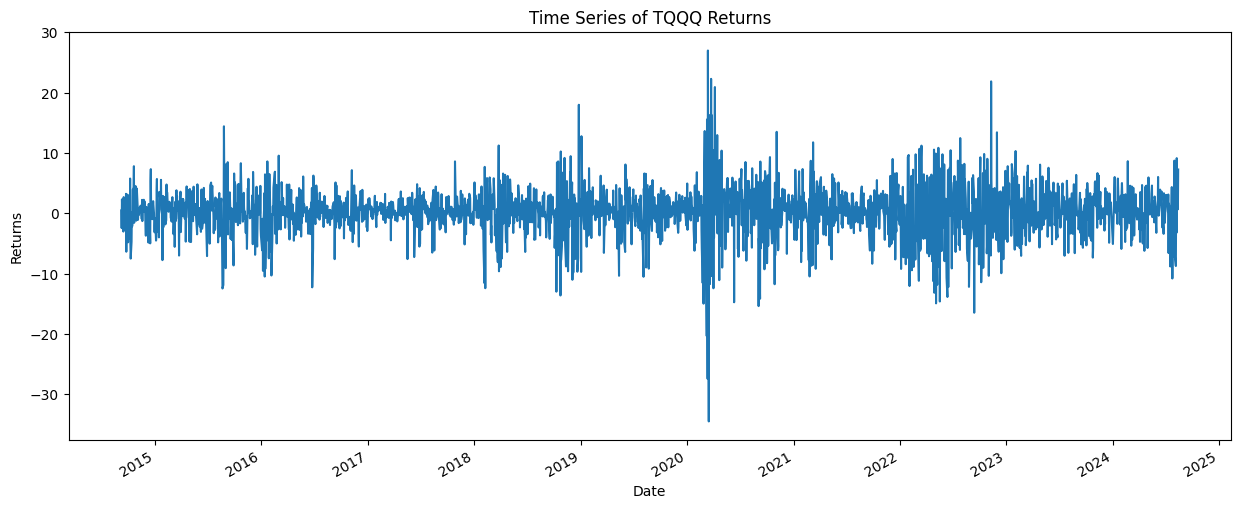

In [81]:
# Creating `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Ploting on `ax`
y_tqqq.plot(ax=ax, label="daily return")

# Adding axis labels
plt.xlabel("Date")
plt.ylabel("Returns")

# Add title
plt.title(f"Time Series of {ticker} Returns");

**13:** Creating an ACF plot of the squared returns.

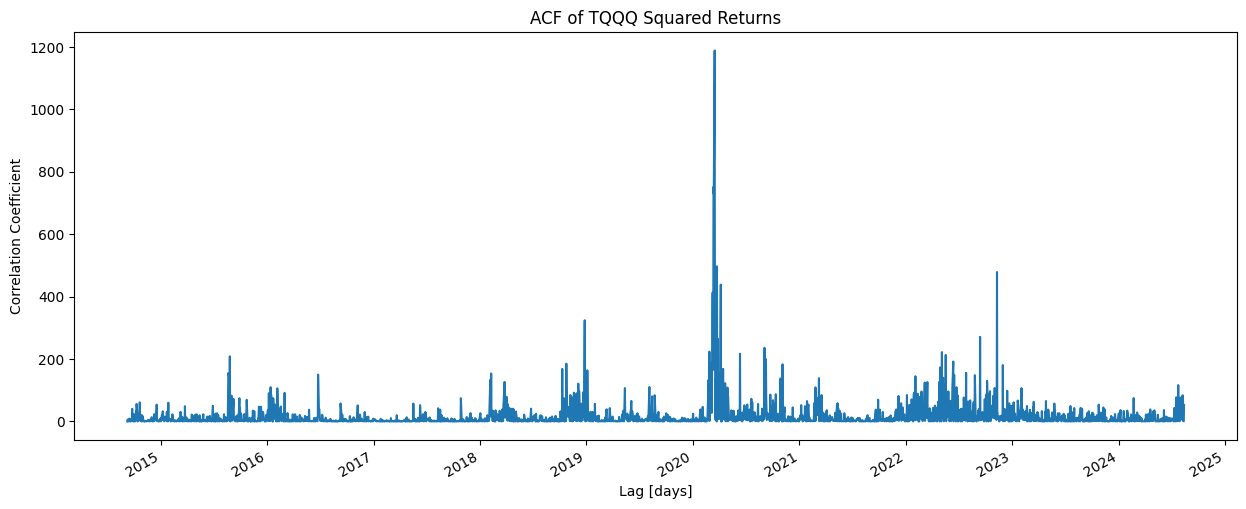

In [82]:
# Creating `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Creating ACF of squared returns
(y_tqqq**2).plot(ax=ax)

# Adding axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")

# Adding title
plt.title(f"ACF of {ticker} Squared Returns");


**14:** Creating a PACF plot of the squared returns.

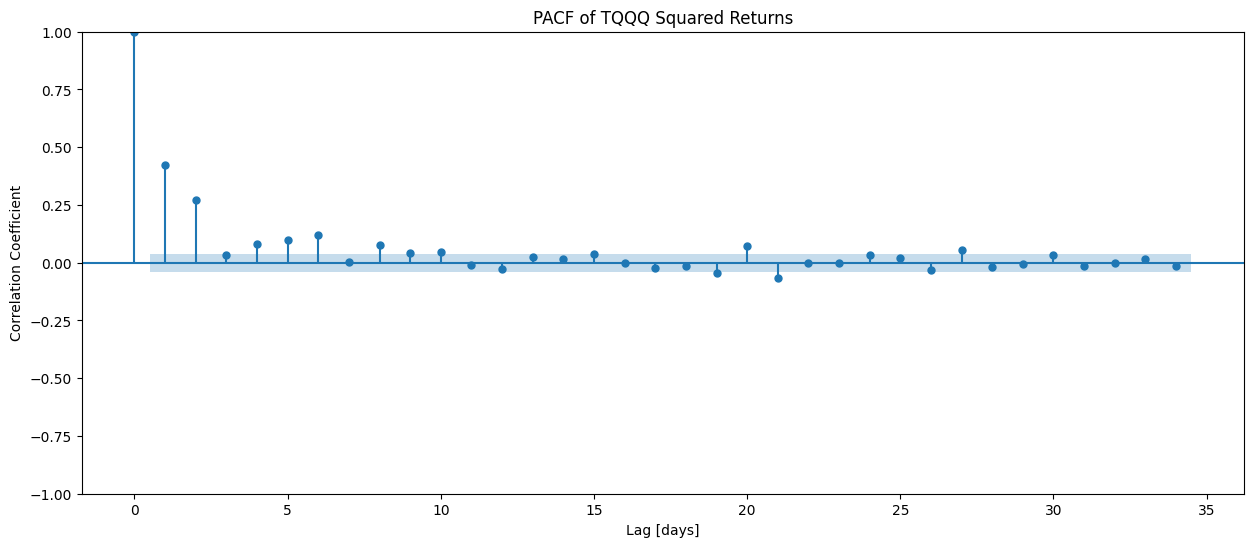

In [83]:
# Creating `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Creating PACF of squared returns
plot_pacf(y_tqqq**2, ax=ax)

# Adding axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")

# Adding title
plt.title(f"PACF of {ticker} Squared Returns");


**15:** Creating a training set that contains the first 80% of the observations.

In [84]:
cutoff_test = int(len(y_tqqq) * 0.8)
y_tqqq_train =  y_tqqq.iloc[:cutoff_test]

print("y_tqqq_train type:", type(y_tqqq_train))
print("y_tqqq_train shape:", y_tqqq_train.shape)
y_tqqq_train.tail()

y_tqqq_train type: <class 'pandas.core.series.Series'>
y_tqqq_train shape: (2000,)


date
2022-08-10    8.212274
2022-08-11   -1.506849
2022-08-12    5.646732
2022-08-15    2.395998
2022-08-16   -0.642839
Name: return, dtype: float64

## Build Model

**16:** Building and fiting a GARCH model using the data.

In [85]:
# Building and training model
model = arch_model(
    y_tqqq_train,
    p=1,
    q=1,
    rescale=False
).fit(disp=0)

print("model type:", type(model))

# Showing model summary
model.summary()

model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5235.97
Distribution:                  Normal   AIC:                           10479.9
Method:            Maximum Likelihood   BIC:                           10502.3
                                        No. Observations:                 2000
Date:                Tue, Aug 13 2024   Df Residuals:                     1999
Time:                        17:33:02   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.3165  6.871e-02      4.606  4.103e-06 [  0.182,  0.451]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.5416      0.149      3.647  2.654e-04 [  0.251,  0.833]
alpha[1]       0.1782  3.011e-02      5.918  3.251e-09 [  0.119,  0.237]
beta[1]        0.7914  3.066e-02     25.813 6.365e-147 [  0.731,  0.852]
========================================================================

Covariance estimator: robust
"""

**17:** Ploting the standardized residuals for the `model`.

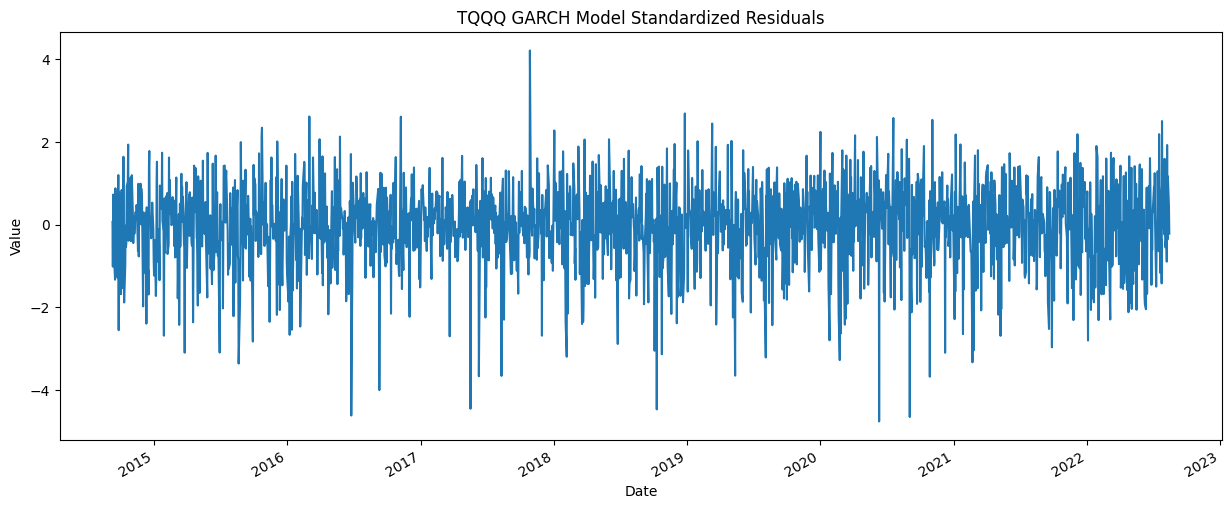

In [86]:
# Creating `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Ploting standardized residuals
model.std_resid.plot(ax=ax, label="Standardized Residuals")

# Adding axis labels
plt.xlabel("Date")
plt.ylabel("Value")

# Adding title
plt.title(f"{ticker} GARCH Model Standardized Residuals");


**18:** Creating an ACF plot of the squared, standardized residuals of the model.

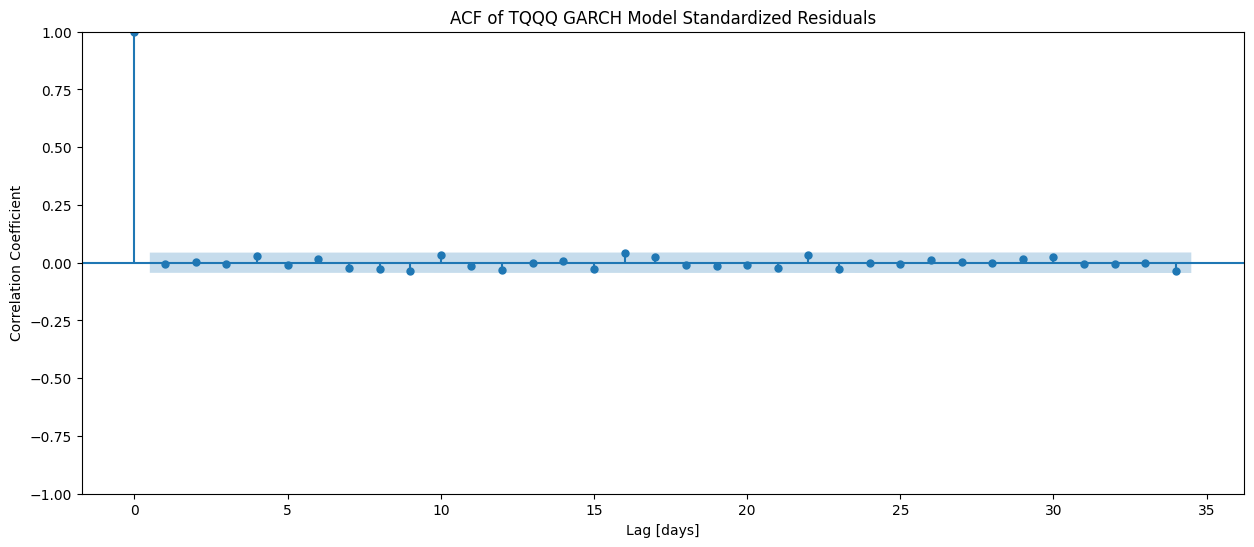

In [87]:
# Creating `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Creating ACF of squared, standardized residuals
plot_acf(model.std_resid**2, ax=ax)

# Adding axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")

# Adding title
plt.title(f"ACF of {ticker} GARCH Model Standardized Residuals");


# Model Deployment

**19:** Starting the app server by entering the following command in command prompt.

```bash
uvicorn main:app --reload --workers 1 --host localhost --port 8008
```

In [88]:
# Importing `build_model` function
from main import build_model

# Building model using new data
model = build_model(ticker="TQQQ", use_new_data=True)

# Wrangle returns
model.wrangle_data(n_observations=2500)

# Fiting GARCH(1,1) model to data
model.fit(p=1, q=1)

In [89]:
# Importing `FitIn` class and `fit_model` function
from main import FitIn, fit_model

# Instantiate `FitIn` object
request = FitIn(ticker="TQQQ", use_new_data=False, n_observations=2500, p=1, q=1)

# Building model and fit to data, following parameters in `request`
fit_out = fit_model(request=request)

# Inspecting `fit_out`
fit_out

Saving model to: models\2024-08-13T17_33_38.021777_TQQQ.pkl


{'ticker': 'TQQQ',
 'use_new_data': False,
 'n_observations': 2500,
 'p': 1,
 'q': 1,
 'success': True,
 'message': "Trained and saved 'models\\2024-08-13T17_33_38.021777_TQQQ.pkl'. Metrics: AIC 14449.876882048047, BIC 14473.173066091473."}

**20:** Creating a `post` request to hit the `"/fit"` path running at `"http://localhost:8008"`. Training a GARCH(1,1) model on 2500 observations of data already downloaded. Passing in the parameters as a dictionary using the `json` argument. 

In [90]:
# URL of `/fit` path
url = "http://localhost:8008/fit"
# Data to be send to path
json = {
    "ticker": "TQQQ",
    "use_new_data": False,
    "n_observations": 2000,
    "p": 1,
    "q": 1
}
# Response of post request
response = requests.post(url=url, json=json)

print("response type:", type(response))
print("response status code:", response.status_code)

response type: <class 'requests.models.Response'>
response status code: 200


**21:** Creating a `post` request to hit the `"/predict"` path running at `"http://localhost:8008"`.  Getting the 5-day volatility forecast.

In [91]:
# URL of `/predict` path
url = "http://localhost:8008/predict"
# Data to be send to path
json = {"ticker": "TQQQ","n_days": 5}
# Response of post request
response = requests.post(url=url, json=json)

print("response type:", type(response))
print("response status code:", response.status_code)
response.json()

response type: <class 'requests.models.Response'>
response status code: 200


{'ticker': 'TQQQ',
 'n_days': 5,
 'success': True,
 'forecast': {'2024-08-14T00:00:00': 5.46772222973846,
  '2024-08-15T00:00:00': 5.4407077218555715,
  '2024-08-16T00:00:00': 5.417944396565735,
  '2024-08-19T00:00:00': 5.398776771473981,
  '2024-08-20T00:00:00': 5.382646556376998},
 'message': ''}